<a name='abstract'></a>
### Abstract

This notebook is intended to use the simple Neural Network (forward network, i.e. Multi-layer Perception Network) to do the prediction of time-series data.

The content is organized as follows: 

- [Data Preprocessing](#data_preprocessing)


- [Simple NN with Keras](#NN_with_Keras)


- [NN model Validation](#model_validation)


- [Fine Tuning](#fine_tuning)


In [1]:
import numpy as np          
import pandas as pd              
import matplotlib.pyplot as plt

import os
import random

import pprint
pp = pprint.PrettyPrinter(indent=4)

from datetime import datetime, timedelta

# configure notebook to display plots
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 100


# import all the utility functions
import time_series_prediction
# in case of change
import importlib

importlib.reload(time_series_prediction)

<module 'time_series_prediction' from '/mnt/sdb/lguo/github/time_series_prediction/time_series_prediction.py'>

<a name='data_preprocessing'></a>
### Data Preprocessing

<div style="text-align:right">  <a href="#abstract">top</a> </div>

In [3]:
# The data file contains the hotel price info around two airports, NCE and MAD
df_hotel_stats = pd.read_csv('sample_hotel_price_data.csv')

print(len(df_hotel_stats))

df_hotel_stats.head()

1257


,25q,75q,airport_code,checkin_date,checkout_date,count,max,mean,median,min,nights,std_dev
0,96.3300,149.8400,MAD,2017-02-01,2017-02-02,13,186.23,132.352308,139.140,77.06,1,36.427673
1,187.8350,298.8775,MAD,2017-02-01,2017-02-03,8,404.57,252.080000,237.710,172.32,2,81.672922
2,49.7275,75.2550,NCE,2017-02-01,2017-02-02,20,86.69,64.992500,66.625,37.46,1,15.717604
3,93.5425,150.5075,NCE,2017-02-01,2017-02-03,20,173.39,129.262500,136.730,74.92,2,31.612035
4,103.5525,149.7050,MAD,2017-02-02,2017-02-03,14,212.99,136.225714,137.320,84.55,1,38.436309


In [4]:

df_time_series = time_series_prediction.extract_time_series(df_hotel_stats, 'NCE')

print('Time steps: ', len(df_time_series))
df_time_series.head()

Time steps:  348


,checkin_date,mean
0,2017-02-01,64.9925
1,2017-02-02,64.2430
2,2017-02-03,62.1060
3,NaN,62.1060
4,2017-02-05,62.5620


In [14]:
df_time_series.tail()

,checkin_date,mean
343,2018-01-08,76.1880
344,2018-01-09,78.1190
345,2018-01-10,77.8585
346,2018-01-11,79.7190
347,2018-01-12,77.7190


In [5]:
#(trainX, trainY, validateX, validateY, testX, testY, scaler) = normalize_input_split(
#    df_time_series['mean'].values, train_test_split = 0.8, look_back=7)


(trainX, trainY, validateX, validateY, testX, testY, scaler) = time_series_prediction.normalize_input_split(
    df_time_series['mean'].values, test_window = 1, look_back=7)


print('=====================')
print('Train X.shape:', trainX.shape, ' sample:', trainX[0])
print('Train Y.shape:', trainY.shape, ' sample:', trainY[0])
print('=====================')
print('Test X.shape:', testX.shape, ' sample:', testX[0])
print('Test Y.shape:', testY.shape, ' sample:', testY[0])

Train X.shape: (334, 7)  sample: [ 0.01432263  0.01196099  0.00522742  0.00522742  0.00666425  0.00204811
  0.01704189]
Train Y.shape: (334,)  sample: 0.0134860491863
Test X.shape: (7, 7)  sample: [ 0.23382383  0.34534789  0.10903376  0.07145243  0.07217242  0.06442739
  0.06703008]
Test Y.shape: (7,)  sample: 0.0618042317206


<a name='NN_with_Keras'></a>
### Simple NN with Keras

Build and train a multi-layer forward neural network with Keras
<div style="text-align:right">  <a href="#abstract">top</a> </div>

In [6]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

import os
# if one sets this variable as "", the code would run on CPUs
os.environ['KERAS_BACKEND'] = "tensorflow"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout


def build_NN_model(input_dim, hidden_layers,
                   optimizer = 'rmsprop', 
                   loss = "mean_squared_error",
                   seed = 7,
                   dropout_rate = None):
    """
    """
    # fix random seed for reproducibility
    np.random.seed(seed)

    # create the pipeline of the network
    model = Sequential()
    
    for index, neuron_num in enumerate(hidden_layers):
        if (index == 0):
            # we just need to specify the input_dim for the first layer,
            #   the input_dim for the rest of layers would be deducted automatically.
            model.add(Dense(neuron_num, input_dim=input_dim, activation='relu'))
        else:
            model.add(Dense(neuron_num, activation='relu'))
    
    if (dropout_rate != None):
        model.add(Dropout(dropout_rate,
                          seed = seed,
                          name="dropout_rate_" + str(dropout_rate)))
    
    # The final output layer, a single neuron, no activation function
    model.add(Dense(1, name='output'))
    
    # other loss functions: mean_absolute_percentage_error
    model.compile(loss=loss, optimizer=optimizer)
    

    return model

In [8]:
model = build_NN_model(input_dim = 7, hidden_layers=[32, 64, 32])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [9]:

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import Callback

class EpochTracker(Callback):
    '''
        Print the log at each epoch
    ''' 
    def on_epoch_end(self, epoch, logs={}):
        print( "\t==> " + str(logs))

        
class ResetStates_per_epoch(Callback):
    '''
        a callback to reset the internal states of model
          at the end of each epoch
    '''
    def on_epoch_end(self, epoch, logs={}):
        self.model.reset_states()
        print('\t epoch:#', epoch)


def train_NN(model, train_config):
    """
    """
    np.random.seed(train_config['seed'])
    
    epochs = train_config['epochs']
    batch_size = train_config['batch_size']
    verbose = train_config['verbose']
    
    # start to reduce the learning rate when the loss value stagnates
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5)

    # quit the epochs when the loss value stops evolving
    # Note: one can monitor on the "val_loss" the loss on the validataion dataset
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='auto')

    callbacks = [reduce_lr, early_stop]    
    if (verbose):
        print_log = EpochTracker()
        callbacks.append(print_log)
    
    results = model.fit(trainX, trainY, 
                        validation_data = (validateX, validateY),
                        callbacks = callbacks,
                        epochs = epochs, 
                        batch_size = batch_size,
                        verbose = verbose)
    
    return (results, model)


def plot_metrics(metrics):
    '''
        Plot the loss evolution during the training process.
    '''   
    ax = plt.subplot(211)

    # plot the evolution of loss and accurary during the training peroid
    ax.plot(metrics['loss'], color='r', marker='o')
    plt.ylabel('loss')
    plt.title('Evolution of losses during the model training')
    plt.xlabel('epochs')

    if ('val_loss' in metrics.keys()):
        ax = plt.subplot(212)
        ax.plot(metrics['val_loss'], marker='o')
        plt.xlabel('epochs')
        _ = plt.ylabel('validation_loss')


Train on 334 samples, validate on 0 samples
Epoch 1/100
334/334 [==============================] - 2s - loss: 0.0065     
Epoch 2/100
334/334 [==============================] - 1s - loss: 0.0053     
Epoch 3/100
334/334 [==============================] - 1s - loss: 0.0049     
Epoch 4/100
334/334 [==============================] - 1s - loss: 0.0046     
Epoch 5/100
334/334 [==============================] - 1s - loss: 0.0047     
Epoch 6/100
334/334 [==============================] - 1s - loss: 0.0045     
Epoch 7/100
334/334 [==============================] - 1s - loss: 0.0046     
Epoch 8/100
334/334 [==============================] - 1s - loss: 0.0043     
Epoch 9/100
334/334 [==============================] - 1s - loss: 0.0045     
Epoch 10/100
334/334 [==============================] - 1s - loss: 0.0042     
Epoch 11/100
334/334 [==============================] - 1s - loss: 0.0041     
Epoch 12/100
334/334 [==============================] - 1s - loss: 0.0041     
Epoch 13/100
334/

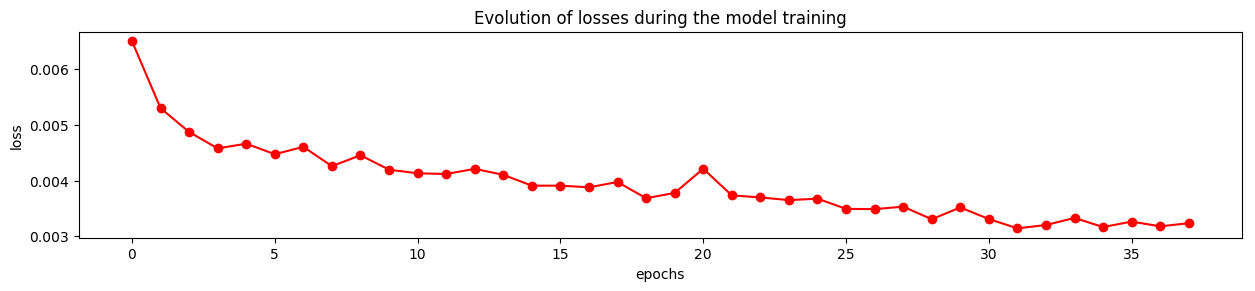

In [11]:
%%time

TRAIN_CONFIG = {
    'seed': 13,
    
    'epochs': 100,
    'batch_size': 1,
    
    # print the training log
    'verbose': True
}

(results, model) = train_NN(model, TRAIN_CONFIG)

plot_metrics(results.history)

<a name='model_validation'></a>
### NN Model Evaluation
<div style="text-align:right">  <a href="#abstract">top</a> </div>


In [13]:
# predict_and_inverse(model, testX, scaler, rolling=False)

sample_KPI = time_series_prediction.evaluate(model, trainX, trainY, testX, testY, scaler, verbose=True)

print('Train MAPE:', sample_KPI['train_mape'])
print('Test MAPE:', sample_KPI['test_mape'])

Train MAPE: 8.20621435823
Test MAPE: 33.4773038611


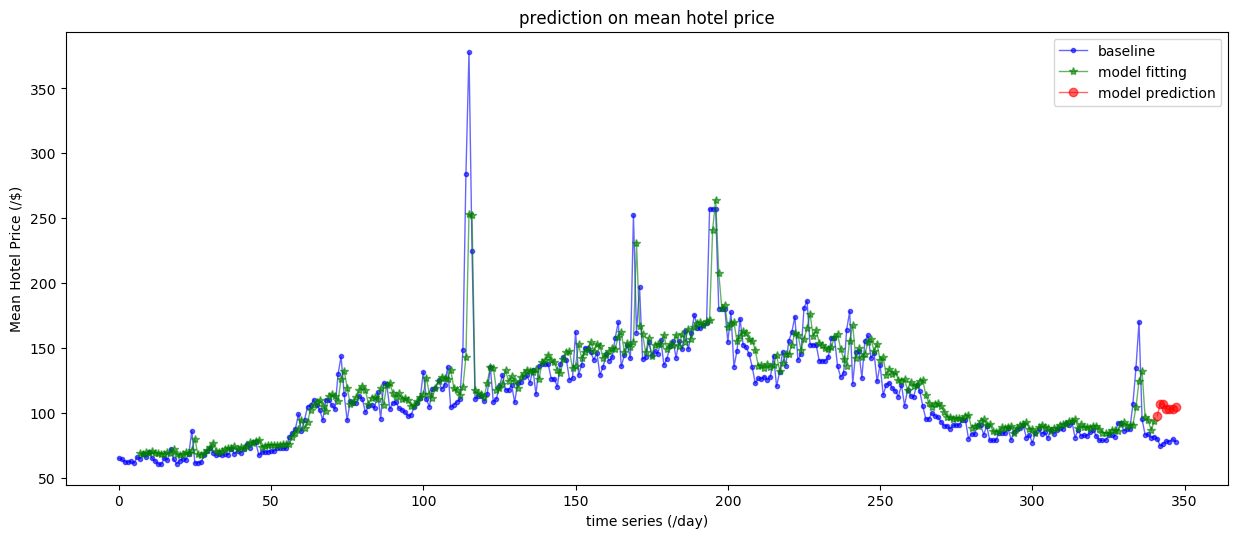

In [14]:
time_series_prediction.plot_benchmark(
               df_time_series['mean'].values,
               sample_KPI['train_predict'],
               sample_KPI['test_predict'],
               look_back = 7)

<a name='batch_benchmark'></a>
### Batch Benchmark
<div style="text-align:right">  <a href="#abstract">top</a> </div>

Do benchmarking on a list of time-series

In [20]:

def run_NN(df_hotel_stats, airport, train_config):
    """
        Benchmark on a specified time-series
        i.e. build, trian and evaluate the model
    """
    look_back = train_config['look_back']  # also the size of feature vector
    hidden_layers = train_config['hidden_layers']
    optimizer = train_config['optimizer']
    loss = train_config['loss']
    seed = train_config['seed']
    dropout_rate = train_config.get('dropout_rate')
    # return the predictions within the KPI metric
    return_predict = train_config.get('return_predict', False)
    
    # Step 1). prepare the data
    df_time_series =  time_series_prediction.extract_time_series(
        df_hotel_stats,
        airport,
        price_type = train_config['price_type'],
        interpolate = train_config['interpolate'])
    
    (trainX, trainY, validateX, validateY, testX, testY, scaler) = \
        time_series_prediction.normalize_input_split(
            df_time_series[train_config['price_type']].values,
            test_window = 1,
            look_back = look_back)

    # Step 2). build the model
    model = build_NN_model(look_back,
                           hidden_layers,
                           optimizer = optimizer, 
                           loss = loss,
                           seed = seed,
                           dropout_rate = dropout_rate)

    if (train_config['verbose']):
        print(model.summary())
    
    # Step 3). train the model
    (results, model) = train_NN(model, train_config)

    # Step 4). test and validate the model
    kpi = time_series_prediction.evaluate(
        model, trainX, trainY, testX, testY, scaler,
        # to include the predicted results or not
        verbose = return_predict)

    # count the number of valid points
    metrics = {
        'sequence_length' : df_time_series['checkin_date'].count(),
    
        # the actual number of epochs, since we have early stopping
        'actual_epochs' : len(results.history['loss']),
        
        # the final loss during the training
        'train_loss': results.history['loss'][-1]
    }
    metrics.update(kpi)
    metrics.update(train_config)
    
    return metrics

In [21]:
%%time


airport_list = df_hotel_stats['airport_code'].unique()


TRAIN_CONFIG = {
    # fix random seed for reproducibility 
    'seed': 13,
    
    'look_back': 7,  # the feature vector
    'hidden_layers': [32, 64, 32],
    
    # optional dropout layer for regularization
    'dropout_rate':  0.1,  # None 
    
    'loss': "mean_squared_error",
    'optimizer': 'adam',

    'epochs': 100,
    'batch_size': 1,
     
    'price_type': 'mean',
    'interpolate': 'nearest', # others: linear, slinear ?
    
    'verbose': True
}


ret = []

for index, airport in enumerate(airport_list[0:1]):
    
    kpi = {'airport_code': airport}
    
    kpi.update(run_NN(df_hotel_stats, airport, TRAIN_CONFIG))

    print(index, kpi)
    
    ret.append(kpi)

#print(ret)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_rate_0.1 (Dropout)   (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________
None
Train on 334 samples, validate on 0 samples
Epoch 1/100
334/334 [==============================] - 2s - loss: 0.0069     
Epoch 2/100
3

In [22]:
df_kpi = pd.DataFrame(ret)

df_kpi.head()

,actual_epochs,airport_code,batch_size,dropout_rate,epochs,hidden_layers,interpolate,look_back,loss,optimizer,price_type,seed,sequence_length,test_ape,test_mape,train_loss,train_mape,verbose
0,23,MAD,1,0.1,100,"[32, 64, 32]",nearest,7,mean_squared_error,adam,mean,13,315,"[9.24589602911, 6.10975322316, 30.9618152735, ...",24.596235,0.003661,18.50241,True


In [120]:
df_kpi['test_mape'].describe()

count     98.000000
mean      23.066696
std       26.249166
min        2.242145
25%        9.272748
50%       15.581070
75%       21.941833
max      154.573200
Name: test_mape, dtype: float64

<a name='fine_tuning'></a>
### Fine Tuning

Looking into some particular examples for hyperparameter tuning

<div style="text-align:right">  <a href="#abstract">top</a> </div>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                256       
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________
None
Train on 334 samples, validate on 0 samples
Epoch 1/100
334/334 [==============================] - 1s - loss: 0.0055     
Epoch 2/100
334/334 [==============================] - 1s - loss: 0.0048     
Epoch 3/100
334/334 [==============================] - 1s - loss: 0

334/334 [==============================] - 1s - loss: 0.0027     
Epoch 38/100
334/334 [==============================] - 1s - loss: 0.0028     
Epoch 39/100
334/334 [==============================] - 1s - loss: 0.0028     
Epoch 40/100
334/334 [==============================] - 1s - loss: 0.0028     
Epoch 41/100
334/334 [==============================] - 1s - loss: 0.0026     
Epoch 42/100
334/334 [==============================] - 0s - loss: 0.0026     
Epoch 43/100
334/334 [==============================] - 1s - loss: 0.0026     
Epoch 44/100
334/334 [==============================] - 1s - loss: 0.0027     
Epoch 45/100
334/334 [==============================] - 1s - loss: 0.0025     
Epoch 46/100
334/334 [==============================] - 1s - loss: 0.0025     
Epoch 47/100
334/334 [==============================] - 1s - loss: 0.0023     
Epoch 48/100
334/334 [==============================] - 1s - loss: 0.0024     
Epoch 49/100
334/334 [==============================] - 1s - loss

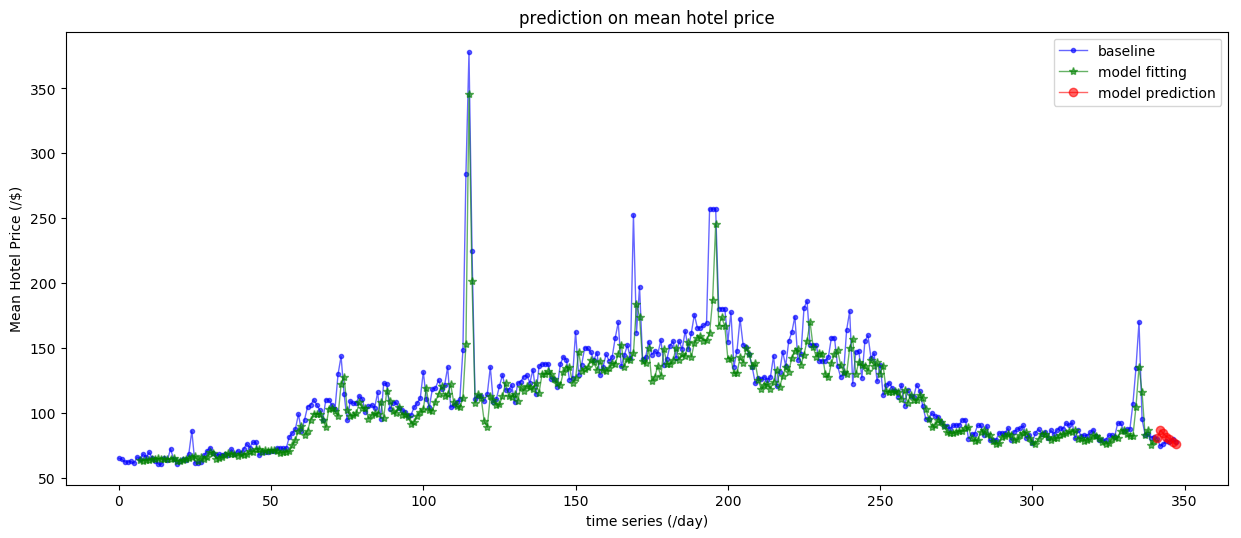

In [24]:

TUNE_CONFIG = {
    # fix random seed for reproducibility 
    'seed': 13,
    
    'look_back': 7,  # the feature vector
    'hidden_layers': [32, 64, 32],
    
    # optional dropout layer for regularization
    'dropout_rate':  None,  # None 
    
    'loss': "mean_squared_error",
    'optimizer': 'adam',

    'epochs': 100,
    'batch_size': 1,
     
    'price_type': 'mean',
    'interpolate': 'nearest', # others: linear, slinear ?
    
    'return_predict': True,
    'verbose': True
}

sample_airport = 'NCE'

sample_KPI = run_NN(df_hotel_stats, sample_airport, TUNE_CONFIG)

print('Train MAPE:', sample_KPI['train_mape'])
print('Test MAPE:', sample_KPI['test_mape'])


sample_time_series =  time_series_prediction.extract_time_series(
        df_hotel_stats, airport = sample_airport)


time_series_prediction.plot_benchmark(
               sample_time_series['mean'].values,
               sample_KPI['train_predict'],
               sample_KPI['test_predict'],
               look_back = 7)